In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyross

In this notebook we consider a control protocol consisting of a lockdown. For our numerical study we generate synthetic data using the deterministic SEkIkIkR model.

While we use the UK age structure and contact matrix, we emphasise that, with the exception of $\beta$, **the model parameters considered in this notebook have NOT been obtained from real data, but rather are chosen ad-hoc**.

**Outline of this notebook:**

1. We briefly summarize the SEkIkIkR model (still to do).
2. We load the age structure and contact matrix for UK. The contact matrix is generally given as
\begin{equation}
    C = C_{H} + C_{W} + C_{S} + C_{O},
\end{equation}
where the four terms denote the number of contacts at home, work, school, and all other remaining contacts.
3. We define the other model parameters of the SEkIkIkR model **(again, these are not fitted to any real data, but rather chosen ad-hoc)**.
4. We define a "lockdown-protocol":
    1. After a fixed time, a lockdown is imposed. The contact matrix is reduced to 
    \begin{equation}
        C = C_{H} + 0.5\cdot C_W + 0.4 \cdot C_O,
        \end{equation}
        i.e. the "home" contacts $C_H$, and 50% of the "work" as well as 40% of the "other" contacts are reainted. The latter two model that at the beginning of lockdown, a significant amount of people still goes to work, and might be lenient in following the lockdown advice.
    2. 2 Days after the initial lockdown, the 40% "social interaction" part of the contact matrix is removed, the work matrix is reduced to 10%, so that we have
        \begin{equation}
        C = C_{H} + 0.1\cdot C_W.
        \end{equation}
        This models that people take the lockdown seriously and seize to interact socially.
5. We run a deterministic simulation of this lockdown protocol, and compare the results to the UK data.

## 2. Load UKage structure and contact matrix

In [3]:
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;

M=16  ## number of age classes

Ni = Ni0[:M]
N=np.sum(Ni)

print("Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).")
print("Number of individuals in each bracket:")
print(Ni.astype('int'))
print("Total number of individuals: {0}".format(np.sum(Ni.astype('int'))))

Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).
Number of individuals in each bracket:
[3951046 4114237 3884626 3684534 4120269 4510345 4683636 4519933 4270785
 4353894 4674918 4463447 3799485 3406990 3329496 2343961]
Total number of individuals: 64111602


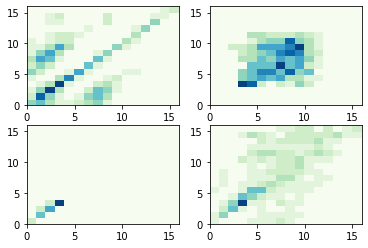

In [4]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.UK()

# By default, home, work, school, and others contribute to the contact matrix
C = CH + CW + CS + CO

# Illustrate the individual contact matrices:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

The above contact matrices illustrate the interactions at home (upper left), work (upper right), school (lower left), and the other remaining contacts (lower right). x- and y- axes denote the age groups, a darker color indicates more interaction.

## 3. Define model parameters

**Note: These have not been fitted to real data.**

In [5]:
alpha=0.3              # fraction of symptomatics who self-isolate
beta = 0.05984224          # probability of infection on contact 
gE   = 1/2.72            # recovery rate of exposeds
kI   = 10;               # # of stages of I class
kE   = 10;                # # of stages of E class 
gIa  = 1./7              # recovery rate of  infectives 
gIs  = 1./17.76
fsa = 0.5

# We start with one symptomatic infective in each of the age groups 6-13
S0 = np.zeros(M)  
I0 = np.zeros((kI,M));
E0 = np.zeros((kE,M));
for i in range(kI):
    I0[i, 6:13]= 1
for i in range(M) :
    S0[i] = Ni[i] - np.sum(I0[:,i]) - np.sum(E0[:,i])
I0 = np.reshape(I0, kI*M)/kI;
E0 = np.reshape(E0, kE*M)/kE;

## 4. Define events for protocol

In [6]:
# Dummy event for initial (standard) contact matrix
events = [lambda t: 1]
contactMatrices = [C]

T_offset = 19 # see fitParamBeta notebook where the beta parameter of the SEkIkIkR model is fitted
# After 20 days, start lockdown
lockdown_threshold_0 = T_offset+19
def event0(t,rp):
    return t - lockdown_threshold_0
events.append(event0)
contactMatrices.append( CH + 0.5*CW + .4*CO ) # for a short time,
                                              # people still have some social contacts

# After 2 days, decrease contacts further
lockdown_threshold_1 = T_offset+21
def event1(t,rp):
    return t- lockdown_threshold_1
events.append(event1)
contactMatrices.append( CH + 0.2*CW)

'''
# After 70 days, add 50% of school contacts to contact matrix
lockdown_threshold_2 = T_offset+260
def event2(t,rp):
    return t - lockdown_threshold_2
events.append(event2)
contactMatrices.append( CH + 0.2*CW + 0.5*CS ) # everybody in lockdown
''';

## 5. Simulate protocol and analyse results

#### Initialise pyross.control, run and plot a single test simulation

In [7]:
# duration of simulation
Tf=500;  Nf=Tf+1;  

# intantiate model
parameters = {'beta':beta, 'gE':gE, 'gIa':gIa, 'gIs':gIs, 
            'kI':kI, 'kE' : kE, 'fsa':fsa, 'alpha':alpha}
model = pyross.control.SEkIkIkR(parameters, M, Ni)

# run model once
data=model.simulate(S0, E0, 0*I0, I0,
                    events,contactMatrices, Tf, Nf)

In [8]:
# Load data
my_data = np.genfromtxt('../data/covid-cases/uk.txt', delimiter='', skip_header=7)
day, cases = my_data[:,0], my_data[:,1]

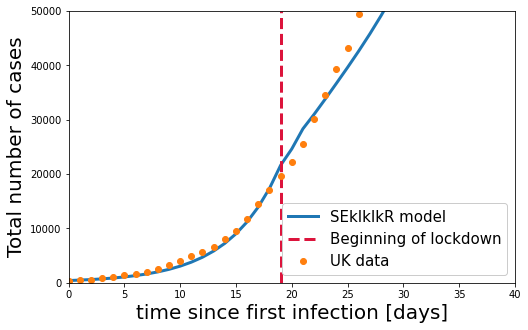

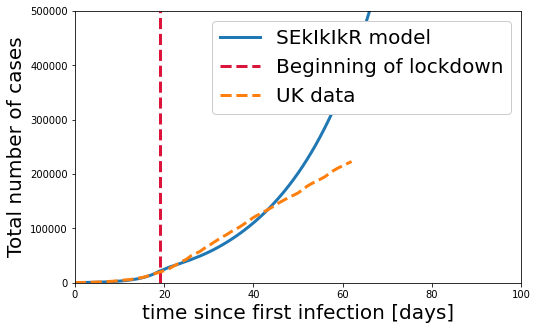

Number of symptomatic infectives (to get a feeling for 'active cases'):


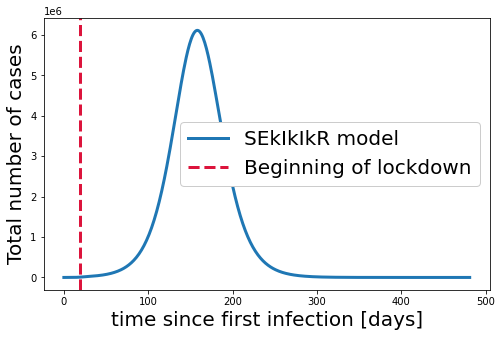

In [9]:
# Plot result

t = data['t']; 
# to compare with the UK dataset, we need the total number of known cases.
# We assume that this is given by
# (All known cases) = (Total population) - (# of suspectibles) + (# of asymptomatics),
Ia = (model.Ia(data))
summedAgesIa = Ia.sum(axis=1)
S = (model.S(data))
summedAgesS = S.sum(axis=1)
trajectory = N - summedAgesS + summedAgesIa
index = T_offset # determined in notebook fitParamBeta, where beta was fitted to the data

lw=3
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(t[index:]-t[index],trajectory[index:],lw=lw,
       label='SEkIkIkR model')
ax.axvline(data['events_occured'][0][0]-t[index],
           color='crimson',lw=lw,
          label='Beginning of lockdown',ls='--')
ax.plot(cases,marker='o',ls='',
       label='UK data')
#ax.set_xlim(0,Tf)
ax.set_xlim(0,40)
ax.set_ylim(0,5e4)
fs=20
ax.legend(loc='best',fontsize=15,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Total number of cases',fontsize=fs)
plt.show()
plt.close()


fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(t[index:]-t[index],trajectory[index:],lw=lw,
       label='SEkIkIkR model')
ax.axvline(data['events_occured'][0][0]-t[index],
           color='crimson',lw=lw,
          label='Beginning of lockdown',ls='--')
ax.plot(cases,#marker='o',
        lw=lw,ls='--',
       label='UK data')
ax.set_xlim(0,100)
ax.set_ylim(0,5e5)
fs=20
ax.legend(loc='best',fontsize=fs,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Total number of cases',fontsize=fs)
fig.savefig('ex7_SEkIkIkR_lockdown.pdf',bbox_inches='tight')
plt.show()
plt.close()



print("Number of symptomatic infectives (to get a feeling for 'active cases'):")
Is = (model.Is(data))
summedAgesIs = Is.sum(axis=1)

fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(t[index:]-t[index],summedAgesIs[index:],lw=lw,
       label='SEkIkIkR model')
ax.axvline(data['events_occured'][0][0]-t[index],
           color='crimson',lw=lw,
          label='Beginning of lockdown',ls='--')
fs=20
ax.legend(loc='best',fontsize=fs,framealpha=1)
ax.set_xlabel('time since first infection [days]',fontsize=fs)
ax.set_ylabel('Total number of cases',fontsize=fs)
plt.show()
plt.close()

(The reader is encouraged to play around with the contact matrices in the lockdown protocol. Even if after 20 days, only the home contact matrix remains, the curvature remains positive and the total number of active cases "explodes".)

**(We emphasise again that the model used here is, except for the parameter $\beta$, not fitted to the UK data!)**